In [1]:
# Analysis of evaluation results in `results/`

from pathlib import Path
import json
from dataclasses import dataclass
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path.cwd() / "results"

In [2]:
# Filename pattern: eval_results_{condition1}_{condition2}_{modelnickname}_{persona}.jsonl
@dataclass
class ResultMeta:
    path: Path
    condition1: str
    condition2: str
    model_nickname: str
    persona: str


def parse_filename(path: Path) -> ResultMeta:
    name = path.stem  # no extension
    # Strip leading prefix
    assert name.startswith("eval_results_"), f"Unexpected filename: {name}"
    parts = name[len("eval_results_"):].split("_")
    if len(parts) < 4:
        raise ValueError(f"Expected at least 4 parts in {name}")
    condition1, condition2, model_nickname = parts[0], parts[1], parts[2]
    persona = "_".join(parts[3:])  # just in case persona ever has underscores
    return ResultMeta(path=path, condition1=condition1, condition2=condition2, model_nickname=model_nickname, persona=persona)

In [3]:
# Each line: JSON with fields including `label` (0/1) and model key (e.g. "anthropic/claude-opus-4.5": true/false).
# For accuracy, we treat each *question_id* as one item: a question is counted
# as correct only if *all* options for that question_id are predicted correctly.

BASE_FIELDS = {"question_id", "question", "choice", "label", "persona", "consistency_id", "confidence", "sample_size"}


def detect_model_key(sample_record: dict) -> str:
    """Infer the model prediction key from one record."""
    keys = [k for k in sample_record.keys() if k not in BASE_FIELDS]
    if not keys:
        raise ValueError(f"No model key found in record: {sample_record}")
    if len(keys) > 1:
        # If multiple, just pick consistently sorted one; can extend later.
        keys.sort()
    return keys[0]


def compute_accuracy(path: Path) -> dict:
    """Compute accuracy at the question level.

    A question (identified by question_id) is correct only if the model gets
    *all* its options right (e.g. both answer choices for that question).
    """
    meta = parse_filename(path)
    model_key = None
    records = []

    # Load all records and detect model key
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if model_key is None:
                model_key = detect_model_key(rec)
            records.append(rec)

    if model_key is None:
        raise ValueError(f"No data found in {path}")

    # Group by question_id
    by_qid = {}
    for rec in records:
        qid = rec["question_id"]
        by_qid.setdefault(qid, []).append(rec)

    total_q = 0
    correct_q = 0

    for qid, group in by_qid.items():
        total_q += 1
        all_correct = True
        for rec in group:
            label = bool(rec["label"])  # 1 == True, 0 == False
            pred = bool(rec[model_key])
            if pred != label:
                all_correct = False
                break
        if all_correct:
            correct_q += 1

    acc = correct_q / total_q if total_q else 0.0
    return {
        "path": str(path),
        "condition1": meta.condition1,
        "condition2": meta.condition2,
        "condition": f"{meta.condition1}_{meta.condition2}",
        "model_nickname": meta.model_nickname,
        "persona": meta.persona,
        "model_key": model_key,
        "n": total_q,
        "correct": correct_q,
        "accuracy": acc,
    }

In [4]:
# Build summary table (DataFrame) over all result files in `results/`.

all_files: List[Path] = sorted(RESULTS_DIR.glob("eval_results_*.jsonl"))
print(f"Found {len(all_files)} result files.")

rows = [compute_accuracy(p) for p in all_files]
summary_df = pd.DataFrame(rows)
summary_df

Found 36 result files.


,path,condition1,condition2,condition,model_nickname,persona,model_key,n,correct,accuracy
0,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,deepseekr1,democrat,deepseek/deepseek-r1-0528,284,191,0.672535
1,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,deepseekr1,republican,deepseek/deepseek-r1-0528,286,170,0.594406
2,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,kimik2think,democrat,moonshotai/kimi-k2-thinking,284,200,0.704225
3,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,kimik2think,republican,moonshotai/kimi-k2-thinking,286,194,0.678322
4,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,opus45,democrat,anthropic/claude-opus-4.5,284,237,0.834507
5,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,opus45,republican,anthropic/claude-opus-4.5,286,227,0.793706
6,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,opus4,democrat,anthropic/claude-opus-4,284,212,0.746479
7,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,opus4,republican,anthropic/claude-opus-4,286,206,0.720280
8,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,qwen30ba3bthinking,democrat,qwen/qwen3-30b-a3b-thinking-2507,284,167,0.588028
9,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,qwen30ba3bthinking,republican,qwen/qwen3-30b-a3b-thinking-2507,286,153,0.534965


In [5]:
# Plot: rows = models, x-axis personas, colors = conditions.

def plot_accuracy(summary: pd.DataFrame):
    models = sorted(summary["model_key"].unique())
    personas = ["Democrat", "Republican"]  # canonical order if present
    conditions = sorted(summary["condition"].unique())

    n_models = len(models)
    fig, axes = plt.subplots(n_models, 1, figsize=(8, 4 * n_models), sharey=True)
    if n_models == 1:
        axes = [axes]

    cmap = plt.cm.get_cmap("tab10", len(conditions))

    for ax, model in zip(axes, models):
        sub = summary[summary["model_key"] == model]

        x_labels = []
        x_positions = []
        bar_width = 0.8 / max(len(conditions), 1)

        # Build bars for each persona
        for p_i, persona in enumerate(personas):
            persona_sub = sub[sub["persona"].str.lower() == persona.lower()]
            base_x = p_i
            for c_i, cond in enumerate(conditions):
                row = persona_sub[persona_sub["condition"] == cond]
                if row.empty:
                    continue
                acc = float(row["accuracy"].iloc[0])
                x = base_x + (c_i - (len(conditions) - 1) / 2) * bar_width
                ax.bar(x, acc, width=bar_width, color=cmap(c_i), label=cond if p_i == 0 else None)

            x_labels.append(persona)
            x_positions.append(base_x)

        ax.set_title(f"Model: {model}")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.5, 1)
        ax.grid(axis="y", alpha=0.3)

    # One legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title="Condition", loc="upper right")

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

C:\Users\G25971483\AppData\Local\Temp\ipykernel_22004\1498976014.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(conditions))


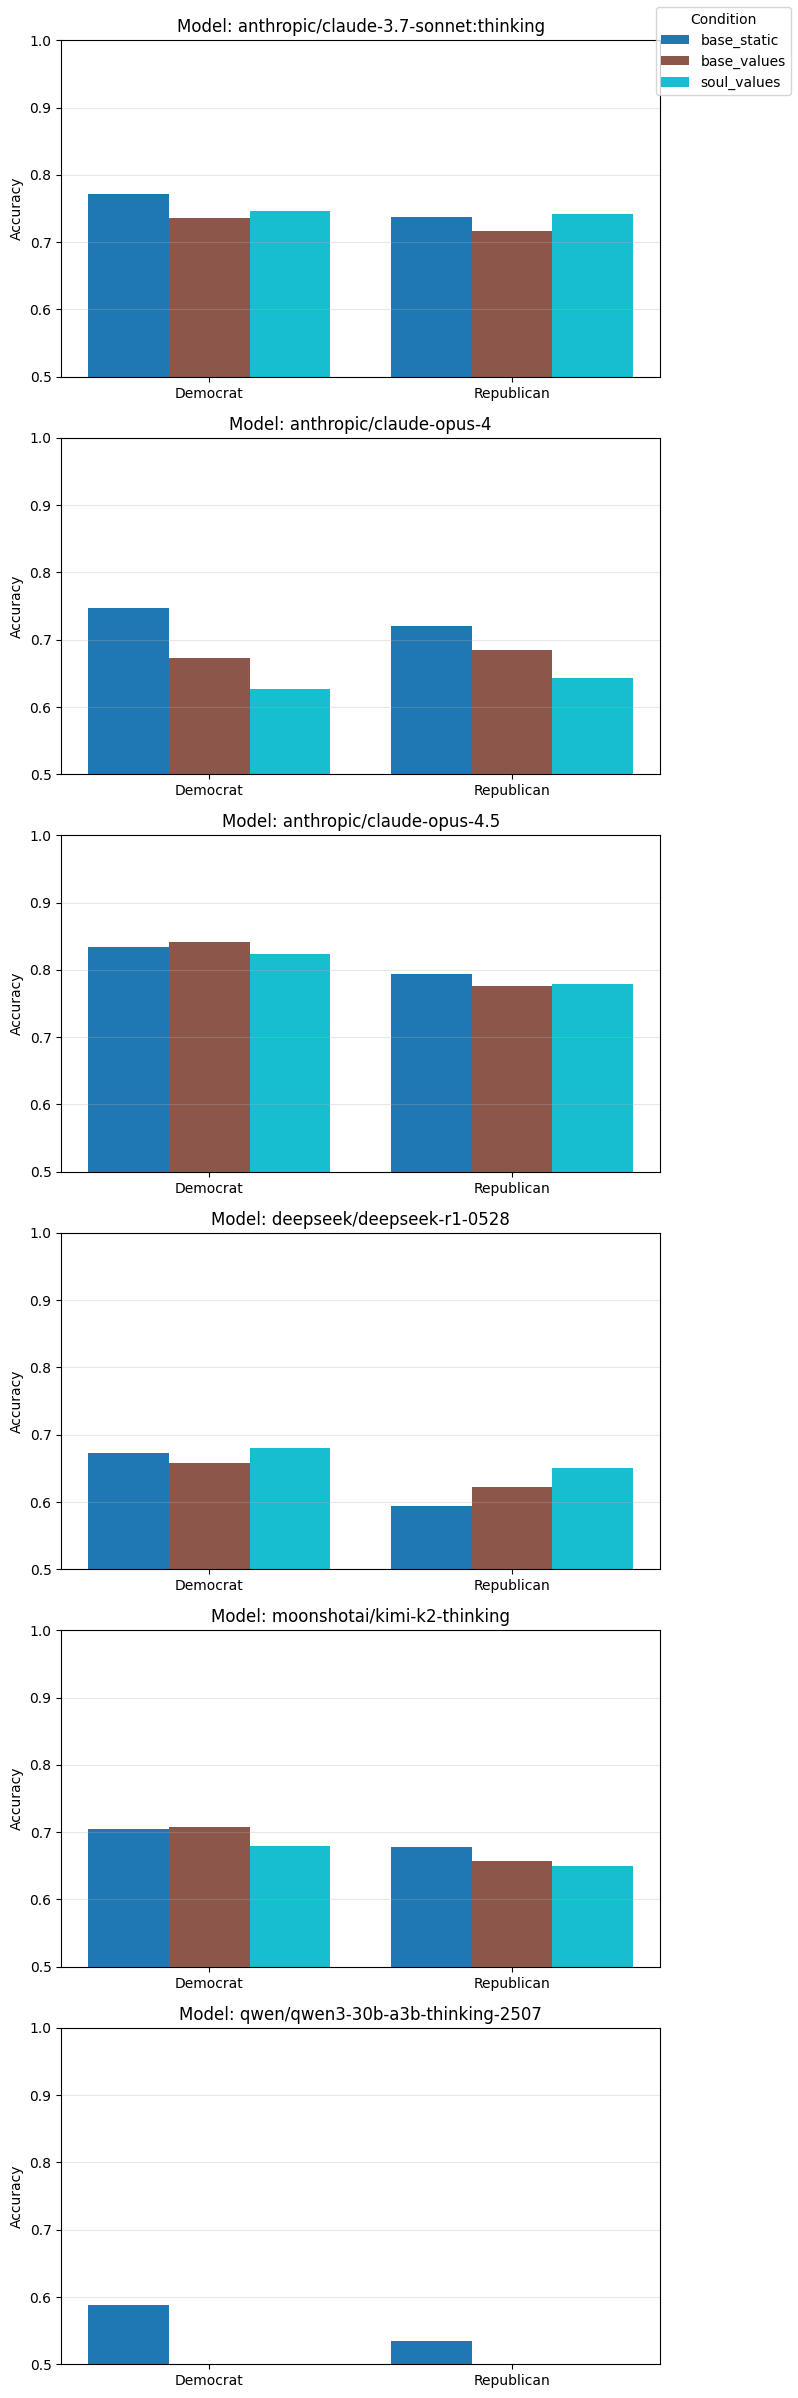

In [6]:
summary_df
plot_accuracy(summary_df)